# 2週目の内容 (画像処理、データ処理)
画像処理の時に役に立ったコレ　https://note.com/kiyo_ai_note/n/ndb9df1fa3d24

## 画像データの準備

week2.ipynbと同じ階層にdata/を配置。train, valと分けて、わんちゃんとねこちゃんのデータをそれぞれ80:20で分割して挿入した。いぬねこは[Kaggle](https://www.kaggle.com/datasets/tongpython/cat-and-dog?resource=download)からもらった。

``` zsh
data
├── train
│   ├── cat
│   └── dog
└── val
    ├── cat
    └── dog
```

## Datasetクラス
torchvision.datasets.ImageFolder()：torchvisionのクラスで、画像をフォルダ構造に基づいて読み込むために使用されます。このクラスは、フォルダ名をクラスラベルとして画像データを自動的にラベリングし、データのロードを効率的に行えるようにします。

引数
- root: データセットのルートディレクトリ
- transform: 画像を適用する変換処理 (リサイズとか正規化)
- loader: 画像を読み込むための関数(デフォルトはPIL)

In [30]:
import torch
import torchvision

train_image_dir = "data/train"
val_image_dir = "data/val"

train_dataset = torchvision.datasets.ImageFolder(root=train_image_dir)
val_dataset = torchvision.datasets.ImageFolder(root=val_image_dir)

print(train_dataset)
print(val_dataset)

Dataset ImageFolder
    Number of datapoints: 160
    Root location: data/train
Dataset ImageFolder
    Number of datapoints: 40
    Root location: data/val


In [31]:
img1, label1 = train_dataset[0]
img2, label2 = val_dataset[-1]

print("img1:{}".format(img1))
print("label1:{}".format(label1))
print("img2:{}".format(img2))
print("label2:{}".format(label2))

img1:<PIL.Image.Image image mode=RGB size=300x224 at 0x7F34640A0CD0>
label1:0
img2:<PIL.Image.Image image mode=RGB size=399x500 at 0x7F346410BC40>
label2:1


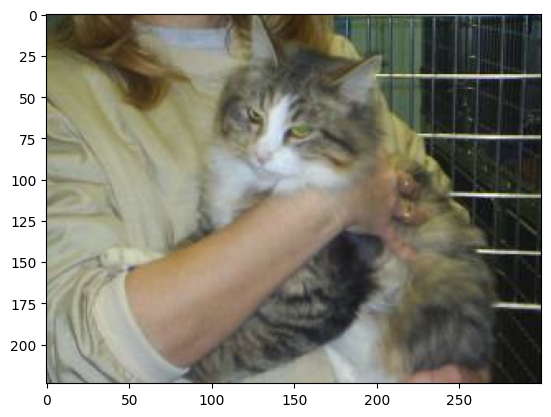

In [32]:
import matplotlib.pyplot as plt

plt.imshow(img1)

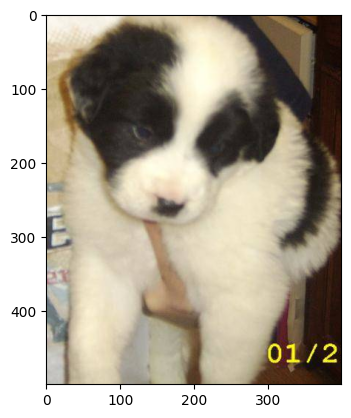

In [33]:
plt.imshow(img2)

## Datasetの変換
### 画像サイズを変更
transforms.RandomResizedCrop()を使うよ
引数は下の順に入れていく
- size (int or sequence) ：トリミング後の出力画像サイズ（値がint型の場合は(size, size)の寸法となる）
- scale (tuple of python:float)：リサイズする上限・下限を設定する。
- ratio (tuple of python:float)：アスペクト比(ランダム)の上限・下限を設定
- interpolation (InterpolationMode)：ー

In [34]:
from torchvision import transforms

resize = transforms.RandomResizedCrop(32)
img1_re = resize(img1)
print("size:{}".format(img1_re.size))
plt.show(img1_re)

size:(32, 32)


### 画像をPyTorchテンソルへ変換する
transformers.ToTensorでできるよ

In [35]:
to_tensor = transforms.ToTensor()
img1_t = to_tensor(img1_re)
print(img1_t.shape)

torch.Size([3, 32, 32])


### サイズを変更し、PyTorchテンソルに変換したデータセットを作成する

transforms.Compose() : 

torchvision.datasets.ImageFolder() : 

.format() : 


In [36]:
import torch
import torchvision
from torchvision import transforms

image_size = 32
train_image_dir = "data/train"
val_image_dir = "data/val"

data_transform = {
    "train" : transforms.Compose([transforms.RandomResizedCrop(image_size),
                                  transforms.ToTensor()]),
    "val" : transforms.Compose([transforms.RandomResizedCrop(image_size),
                                transforms.ToTensor()])
}

tensor_train_dataset = torchvision.datasets.ImageFolder(
                            root=train_image_dir,
                            transform=data_transform["train"])
tensor_val_dataset = torchvision.datasets.ImageFolder(
                        root=val_image_dir,
                        transform=data_transform["val"])

img1_t, label = tensor_train_dataset[0]
print("type:{}, label:{}, shape:{}, dtype:{}".format(
                                                type(img1_t),
                                                label,
                                                img1_t.shape,
                                                img1_t.dtype))

img2_t, label = tensor_train_dataset[0]
print("type:{}, label:{}, shape:{}, dtype:{}".format(
                                                type(img2_t),
                                                label,
                                                img2_t.shape,
                                                img2_t.dtype))



type:<class 'torch.Tensor'>, label:0, shape:torch.Size([3, 32, 32]), dtype:torch.float32
type:<class 'torch.Tensor'>, label:0, shape:torch.Size([3, 32, 32]), dtype:torch.float32


In [37]:
print("min:{}, max:{}".format(img1_t.min(), img1_t.max()))

min:0.0784313753247261, max:0.9098039269447327


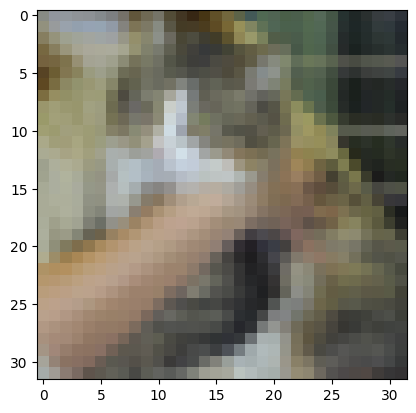

In [38]:
plt.imshow(img1_t.permute(1, 2, 0))

### データの正規化

正規化する理由は0±1あたりで線形である活性化関数を選択する際に使いやすいから！

In [39]:
imgs = torch.stack([img_t for img_t, _ in tensor_train_dataset], dim=3)
print(imgs.shape)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)
print("mean:{}, std:{}".format(mean, std))

torch.Size([3, 32, 32, 160])
mean:tensor([0.4942, 0.4572, 0.4213]), std:tensor([0.2467, 0.2342, 0.2359])


In [40]:
import torch
import torchvision
from torchvision import transforms

image_size = 32
mean = (0.5022, 0.4638, 0.4274)
std = (0.2466, 0.2347, 0.2386)
train_image_dir = "data/train"
val_image_dir = "data/val"

data_transform = {
    'train': transforms.Compose([transforms.RandomResizedCrop(image_size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)]),

    'val': transforms.Compose([transforms.RandomResizedCrop(image_size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)])
}

train_dataset = torchvision.datasets.ImageFolder(
                                        root=train_image_dir,
                                        transform=data_transform["train"])
val_dataset = torchvision.datasets.ImageFolder(
                                    root=train_image_dir,
                                    transform=data_transform["val"])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5753225..2.0711174].


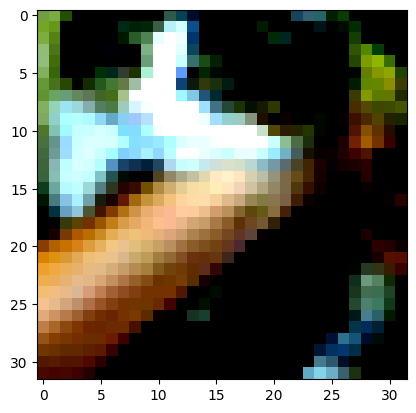

In [41]:
img, label = train_dataset[0]
plt.imshow(img.permute(1, 2, 0))

## 分類画像モデルの構築

In [13]:
import torch
import torch.nn as nn

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print("device:{}".format(device))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)).to(device=device)

learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_ephocs = 50

for epoch in range(n_ephocs):
    for imgs, labels in train_loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch:{}, Loss:{:.3f}".format(epoch, float(loss)))

device:cuda
Epoch:0, Loss:0.665
Epoch:1, Loss:0.914
Epoch:2, Loss:0.797
Epoch:3, Loss:0.742
Epoch:4, Loss:0.566
Epoch:5, Loss:0.537
Epoch:6, Loss:0.643
Epoch:7, Loss:0.842
Epoch:8, Loss:0.859
Epoch:9, Loss:0.563
Epoch:10, Loss:0.754
Epoch:11, Loss:0.727
Epoch:12, Loss:0.557
Epoch:13, Loss:0.789
Epoch:14, Loss:0.534
Epoch:15, Loss:0.655
Epoch:16, Loss:0.864
Epoch:17, Loss:0.680
Epoch:18, Loss:0.568
Epoch:19, Loss:0.629
Epoch:20, Loss:0.708
Epoch:21, Loss:0.497
Epoch:22, Loss:0.683
Epoch:23, Loss:0.828
Epoch:24, Loss:0.491
Epoch:25, Loss:0.790
Epoch:26, Loss:0.643
Epoch:27, Loss:0.628
Epoch:28, Loss:0.824
Epoch:29, Loss:0.686
Epoch:30, Loss:0.526
Epoch:31, Loss:0.893
Epoch:32, Loss:0.582
Epoch:33, Loss:0.643
Epoch:34, Loss:0.658
Epoch:35, Loss:0.843
Epoch:36, Loss:0.605
Epoch:37, Loss:0.742
Epoch:38, Loss:0.651
Epoch:39, Loss:0.707
Epoch:40, Loss:0.581
Epoch:41, Loss:0.644
Epoch:42, Loss:0.374
Epoch:43, Loss:0.653
Epoch:44, Loss:0.553
Epoch:45, Loss:0.469
Epoch:46, Loss:0.559
Epoch:47, L

In [14]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, label in val_loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
    
print("Accuracy:{:.3f}".format(float(correct/total)))

Accuracy:0.525


## 演習
### 1. エポック数 (学習回数)を変化させた時の損失関数の値と予測精度を調査する。

pytable使って表を作れそう
https://qiita.com/arakiii/items/5bece948dd459b53d0b8

In [15]:
import torch
import torch.nn as nn

def ThisNN(ep):
    # 学習して各エポックに対する損失の値を出すフェーズ
    device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    # print("device:{}".format(device))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

    model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1)).to(device=device)

    learning_rate = 1e-2
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = nn.NLLLoss()
    n_ephocs = ep

    for epoch in range(n_ephocs):
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    nowLoss = "Epoch:{}, Loss:{:.3f}".format(epoch, float(loss))

    # 評価するフェーズ
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, label in val_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            
        nowAccuracy = float(correct/total)

    # 損失を返す
    return float(loss), float(correct/total)

In [16]:
epochList = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
lossList = []
accList = []

for epoch in epochList:
    loss, accuracy = ThisNN(epoch)
    # 小数点3けたに丸める
    loss = round(loss, 3)
    accuracy = round(accuracy, 3)
    
    lossList.append(loss)
    accList.append(accuracy)
    print(f"ephoc:{epoch}の学習終了")

print(epochList)
print(lossList)
print(accList)

ephoc:10の学習終了
ephoc:20の学習終了
ephoc:30の学習終了
ephoc:40の学習終了
ephoc:50の学習終了
ephoc:60の学習終了
ephoc:70の学習終了
ephoc:80の学習終了
ephoc:90の学習終了
ephoc:100の学習終了
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.579, 0.837, 0.547, 0.671, 0.743, 0.769, 0.832, 0.522, 0.788, 0.43]
[0.475, 0.456, 0.487, 0.475, 0.481, 0.531, 0.55, 0.5, 0.506, 0.525]


### 2. 活性化関数を変えた場合の損失関数の値と予測制度を調査する。
ReLUにした場合　(epoch 10~100で10刻み)

In [17]:
import torch
import torch.nn as nn

def ReLUNN(ep):
    # 学習して各エポックに対する損失の値を出すフェーズ
    device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    # print("device:{}".format(device))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

    model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.ReLU(),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1)).to(device=device)

    learning_rate = 1e-2
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = nn.NLLLoss()
    n_ephocs = ep

    for epoch in range(n_ephocs):
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    nowLoss = "Epoch:{}, Loss:{:.3f}".format(epoch, float(loss))

    # 評価するフェーズ
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, label in val_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            
        nowAccuracy = float(correct/total)

    # 損失を返す
    return float(loss), float(correct/total)

In [18]:
epochList = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
r_lossList = []
r_accList = []

for epoch in epochList:
    r_loss, r_accuracy = ReLUNN(epoch)
    # 小数点3けたに丸める
    r_loss = round(r_loss, 3)
    r_accuracy = round(r_accuracy, 3)
    
    r_lossList.append(r_loss)
    r_accList.append(r_accuracy)
    print(f"epoch: {epoch} の学習終了")

print(epochList)
print(r_lossList)
print(r_accList)

epoch: 10 の学習終了
epoch: 20 の学習終了
epoch: 30 の学習終了
epoch: 40 の学習終了
epoch: 50 の学習終了
epoch: 60 の学習終了
epoch: 70 の学習終了
epoch: 80 の学習終了
epoch: 90 の学習終了
epoch: 100 の学習終了
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.654, 0.319, 0.596, 0.694, 0.526, 0.581, 0.364, 0.57, 0.278, 0.397]
[0.475, 0.644, 0.463, 0.425, 0.544, 0.475, 0.431, 0.456, 0.519, 0.481]


## 活性化関数HPTとReLUの比較
### 損失について

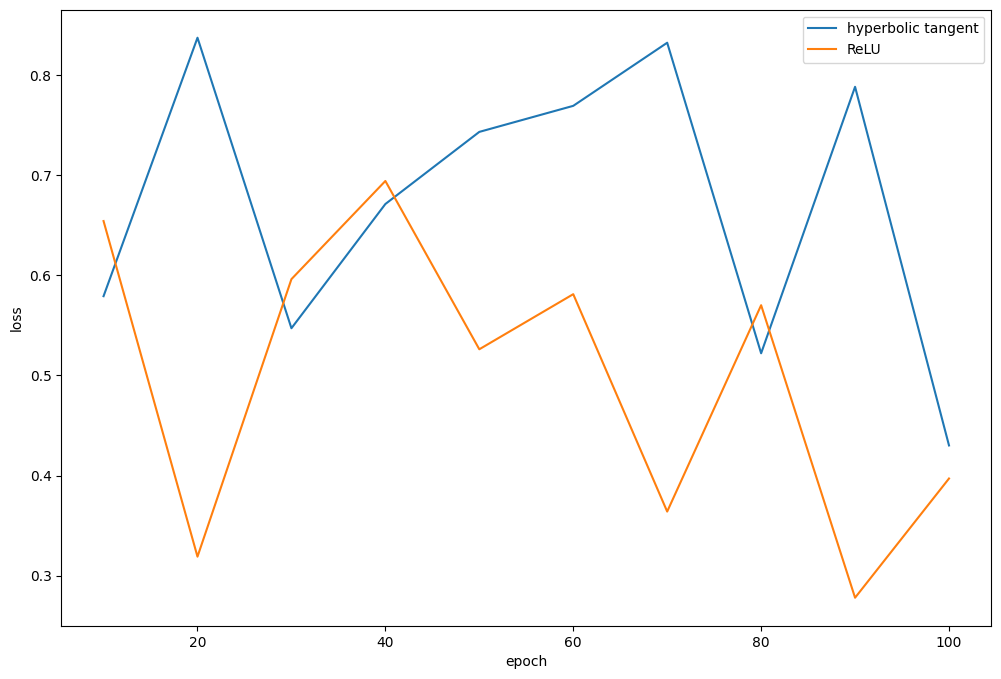

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

x = epochList
y_loss1 = lossList
y_loss2 = r_lossList

ax.plot(x, y_loss1, label='hyperbolic tangent')
ax.plot(x, y_loss2, label='ReLU')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')

plt.legend(loc='best')
plt.show()

### 精度について

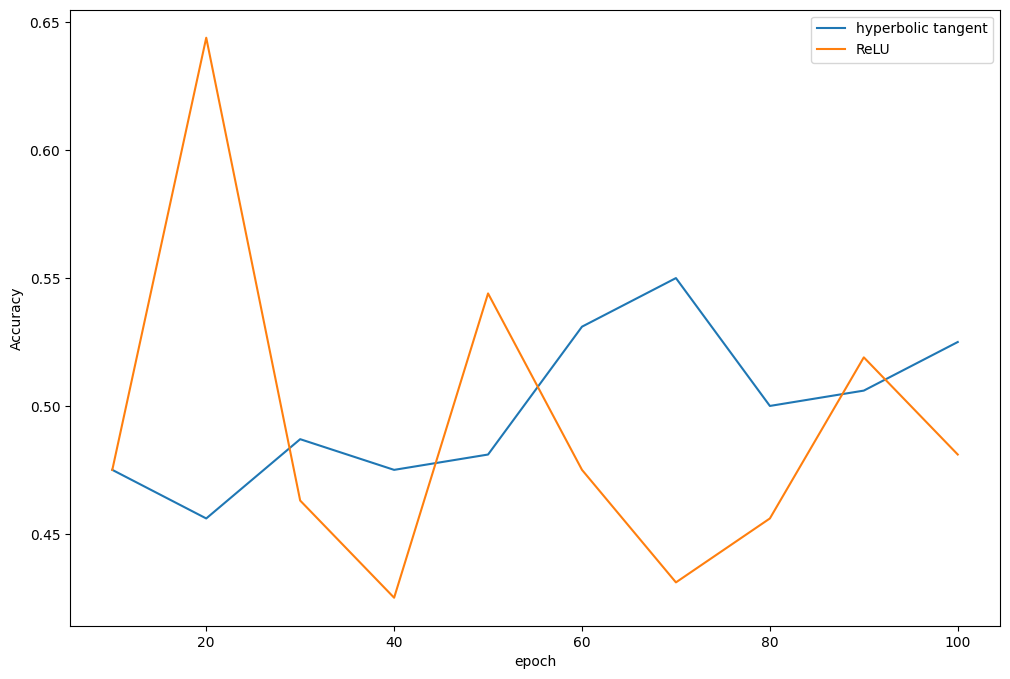

In [20]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

x = epochList
y_acc1 = accList
y_acc2 = r_accList

ax.plot(x, y_acc1, label='hyperbolic tangent')
ax.plot(x, y_acc2, label='ReLU')

ax.set_xlabel('epoch')
ax.set_ylabel('Accuracy')

plt.legend(loc='best')
plt.show()

### 3. ネットワークの構造を変えた場合の損失関数の値と予測精度を調査する。

In [21]:
import torch
import torch.nn as nn

def GoodNN(ep):
    # 学習して各エポックに対する損失の値を出すフェーズ
    device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    # print("device:{}".format(device))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

    model = nn.Sequential(
        nn.Linear(3072, 1024),
        nn.Tanh(),
        nn.Linear(1024, 512),
        nn.Tanh(),
        nn.Linear(512, 128),
        nn.Tanh(),
        nn.Linear(128, 2),
        nn.LogSoftmax(dim=1)).to(device=device)

    learning_rate = 1e-2
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = nn.NLLLoss()
    n_ephocs = ep

    for epoch in range(n_ephocs):
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    nowLoss = "Epoch:{}, Loss:{:.3f}".format(epoch, float(loss))

    # 評価するフェーズ
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, label in val_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            
        nowAccuracy = float(correct/total)

    # 損失を返す
    return float(loss), float(correct/total)

In [22]:
epochList = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
g_lossList = []
g_accList = []

for epoch in epochList:
    g_loss, g_accuracy = GoodNN(epoch)
    # 小数点3けたに丸める
    g_loss = round(g_loss, 3)
    g_accuracy = round(g_accuracy, 3)
    
    g_lossList.append(g_loss)
    g_accList.append(g_accuracy)
    print(f"ephoc:{epoch}の学習終了")

print(epochList)
print(g_lossList)
print(g_accList)

ephoc:10の学習終了
ephoc:20の学習終了
ephoc:30の学習終了
ephoc:40の学習終了
ephoc:50の学習終了
ephoc:60の学習終了
ephoc:70の学習終了
ephoc:80の学習終了
ephoc:90の学習終了
ephoc:100の学習終了
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.689, 0.822, 0.85, 0.63, 0.635, 0.726, 0.735, 0.794, 0.601, 0.797]
[0.425, 0.438, 0.5, 0.406, 0.487, 0.519, 0.494, 0.544, 0.419, 0.494]


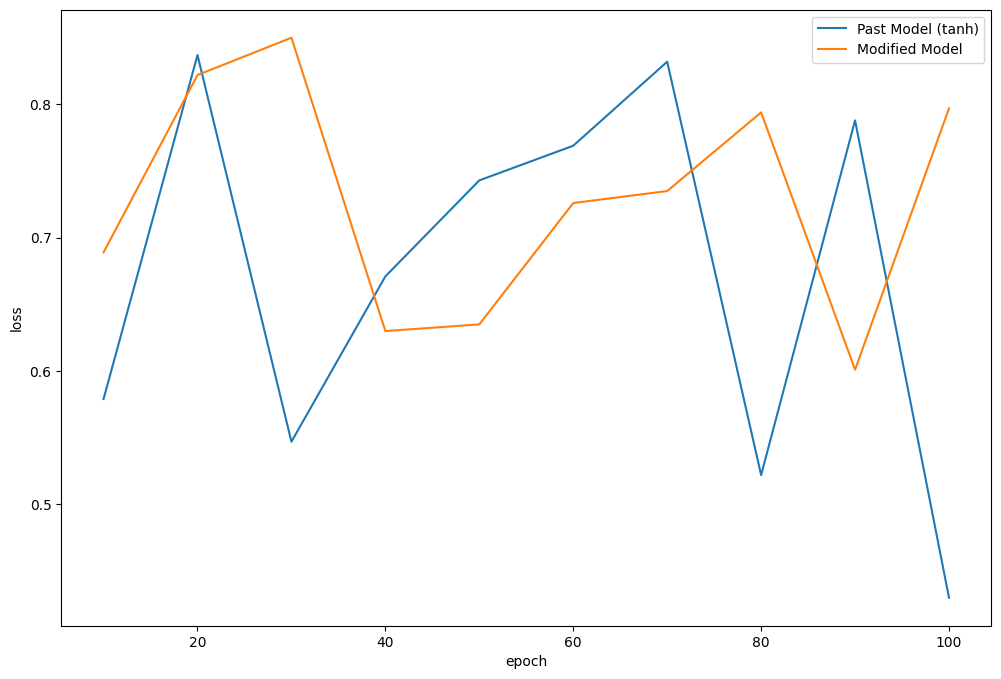

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

x = epochList
y_loss1 = lossList
y_loss3 = g_lossList

ax.plot(x, y_loss1, label='Past Model (tanh)')
ax.plot(x, y_loss3, label='Modified Model')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
        
plt.legend(loc='best')
plt.show()

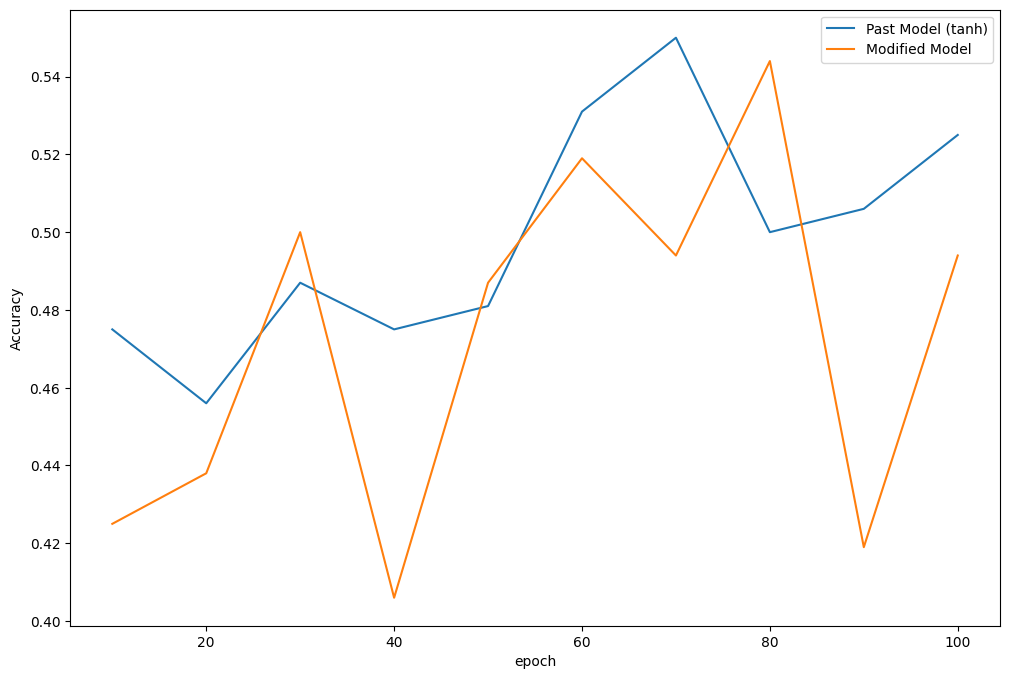

In [24]:
fig = plt.figure(figsize=(12, 8))
bx = fig.add_subplot(111)

x = epochList
y_acc1 = accList
y_acc2 = r_accList
y_acc3 = g_accList

bx.plot(x, y_acc1, label='Past Model (tanh)')
bx.plot(x, y_acc3, label='Modified Model')

bx.set_xlabel('epoch')
bx.set_ylabel('Accuracy')

plt.legend(loc='best')
plt.show()